In [157]:
#получение обучающей, тестовой и тестовой выборки
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

dbname = 'football'
user = 'postgres'
password = 'TheDarkKhight'
host = 'localhost'
port = 5432

In [2]:
conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)

In [3]:
sql_test_data = "SELECT id as fixtureID, timestamp as time, home_id, home_goals, away_id, away_goals FROM test_sample_matches WHERE type = 'test'"
sql_valid_data = "SELECT id as fixtureID, timestamp as time, home_id, home_goals, away_id, away_goals FROM test_sample_matches WHERE type = 'valid'"
sql_train_data = "SELECT id as fixtureID, timestamp as time, home_id, home_goals, away_id, away_goals FROM test_sample_matches WHERE type = 'train'"
test_data = pd.read_sql_query(sql_test_data, conn)
valid_data = pd.read_sql_query(sql_valid_data, conn)
train_data = pd.read_sql_query(sql_train_data, conn)

C:\Users\arbol\AppData\Local\Temp\ipykernel_32308\466267492.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  test_data = pd.read_sql_query(sql_test_data, conn)
C:\Users\arbol\AppData\Local\Temp\ipykernel_32308\466267492.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  valid_data = pd.read_sql_query(sql_valid_data, conn)
C:\Users\arbol\AppData\Local\Temp\ipykernel_32308\466267492.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  train_data = pd.read_sql_query(sql_train_data, conn)


In [4]:
conn.close()

In [5]:
match_data = pd.read_csv('match_data.csv',index_col='id')

In [174]:
def create_samples(data):
    y = []
    x = []
    for _, row in data.iterrows():
        new_line_home = []
        new_line_away = []
        home_team_data = match_data[(match_data['team_id'] == row['home_id']) & (match_data['time'] < row['time'])][-15::]
        away_team_data = match_data[(match_data['team_id'] == row['away_id']) & (match_data['time'] < row['time'])][-15::]
        hh = home_team_data[home_team_data['position'] == 'home']
        ha = home_team_data[home_team_data['position'] == 'away']

        ah = away_team_data[away_team_data['position'] == 'home']
        aa = away_team_data[away_team_data['position'] == 'away']

        new_line_home.extend([row['home_id'], row['time'], hh['goals'].mean(), ha['goals'].mean(), hh['shots'].mean(), ha['shots'].mean(), hh['xg'].mean(), ha['xg'].mean()])
        new_line_away.extend([row['away_id'], row['time'], ah['goals'].mean(), aa['goals'].mean(), ah['shots'].mean(), aa['shots'].mean(), ah['xg'].mean(), aa['xg'].mean()])

        x.extend([new_line_home, new_line_away]) 
        y.extend([[0.5, row['home_goals'] if row['home_goals'] > 0 else 0.2], [1, row['away_goals'] if row['away_goals'] > 0 else 0.2]])
        #y.extend([[1, row['home_goals']], [2, row['away_goals']]])
    return x, y

x_test, y_test = create_samples(test_data)
x_test = pd.DataFrame(x_test, columns=['team_id','time', 'mean_goals_home', 'mean_goals_away', 'shots_home', 'shots_away', 'xg_home', 'xg_away'])
y_test = pd.DataFrame(y_test, columns=['position', 'actual_goal'])

In [176]:
all_test = pd.concat([x_test, y_test], axis=1)
all_test_home = all_test[all_test['position'] == 0.5].reset_index(drop=True)
all_test_away = all_test[all_test['position'] == 1].reset_index(drop=True)
all_test_home

,team_id,time,mean_goals_home,mean_goals_away,shots_home,shots_away,xg_home,xg_away,position,actual_goal
0,1088,1689955200,1.000000,1.375000,4.571429,3.375000,1.000000,1.375000,0.5,1.0
1,1084,1690020000,1.142857,0.750000,3.142857,2.250000,1.142857,0.750000,0.5,2.0
2,558,1690122600,1.777778,1.000000,6.000000,5.333333,1.777778,1.000000,0.5,3.0
3,2012,1690131600,1.125000,0.428571,4.375000,2.714286,1.125000,0.428571,0.5,2.0
4,779,1690131600,1.333333,1.111111,5.500000,3.444444,1.333333,1.111111,0.5,2.0
...,...,...,...,...,...,...,...,...,...,...
85,621,1696694400,1.625000,1.714286,4.250000,5.142857,1.908750,1.971429,0.5,3.0
86,52,1696696200,1.428571,0.750000,4.571429,3.875000,1.297143,0.930000,0.5,0.2
87,39,1696770000,1.428571,0.625000,3.857143,2.500000,1.098571,0.953750,0.5,1.0
88,1088,1696771800,2.166667,1.555556,6.833333,5.222222,2.140000,1.172222,0.5,0.2


In [144]:
all_test_away.corr()

,team_id,time,mean_goals_home,mean_goals_away,shots_home,shots_away,xg_home,xg_away,position,actual_goal
team_id,1.000000,-0.234983,-0.319676,-0.215130,-0.516599,-0.249178,-0.338108,-0.165984,NaN,-0.259400
time,-0.234983,1.000000,0.030420,-0.151105,0.061874,-0.060818,0.023846,-0.130569,NaN,0.002024
mean_goals_home,-0.319676,0.030420,1.000000,0.374199,0.512493,0.318301,0.772665,0.250235,NaN,0.195736
mean_goals_away,-0.215130,-0.151105,0.374199,1.000000,0.272999,0.623266,0.373214,0.879226,NaN,0.167257
shots_home,-0.516599,0.061874,0.512493,0.272999,1.000000,0.504430,0.685561,0.240892,NaN,0.289006
shots_away,-0.249178,-0.060818,0.318301,0.623266,0.504430,1.000000,0.420134,0.598137,NaN,0.169598
xg_home,-0.338108,0.023846,0.772665,0.373214,0.685561,0.420134,1.000000,0.350438,NaN,0.215440
xg_away,-0.165984,-0.130569,0.250235,0.879226,0.240892,0.598137,0.350438,1.000000,NaN,0.167122
position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
actual_goal,-0.259400,0.002024,0.195736,0.167257,0.289006,0.169598,0.215440,0.167122,NaN,1.000000


In [178]:
x_valid, y_valid = create_samples(valid_data)

In [179]:
x_valid = pd.DataFrame(x_valid, columns=['team_id','time', 'mean_goals_home', 'mean_goals_away', 'shots_home', 'shots_away', 'xg_home', 'xg_away'])
y_valid = pd.DataFrame(y_valid, columns=['position', 'actual_goal'])
all_valid = pd.concat([x_valid, y_valid], axis=1)
all_valid_home = all_valid[all_valid['position'] == 0.5].reset_index(drop=True)
all_valid_away = all_valid[all_valid['position'] == 1].reset_index(drop=True)
all_valid_home

,team_id,time,mean_goals_home,mean_goals_away,shots_home,shots_away,xg_home,xg_away,position,actual_goal
0,1080,1666965600,2.428571,1.000000,7.857143,5.000000,2.428571,1.000000,0.5,4.0
1,596,1667655000,4.285714,1.750000,9.714286,5.000000,4.285714,1.750000,0.5,1.0
2,555,1667664000,2.857143,1.125000,6.428571,3.625000,2.857143,1.125000,0.5,0.2
3,1079,1668250800,0.857143,1.125000,5.571429,5.000000,0.857143,1.125000,0.5,1.0
4,39,1668282300,0.750000,0.428571,3.250000,3.857143,0.750000,0.428571,0.5,0.2
...,...,...,...,...,...,...,...,...,...,...
85,596,1695562200,2.200000,1.700000,5.200000,3.100000,1.580000,1.361000,0.5,1.0
86,1993,1695657600,1.000000,0.555556,3.833333,2.333333,1.261667,0.801111,0.5,0.2
87,39,1696082400,1.285714,0.625000,4.285714,2.500000,1.110000,0.953750,0.5,2.0
88,1085,1696176000,2.000000,0.714286,4.500000,2.857143,2.322500,0.628571,0.5,1.0


In [180]:
all_valid_away.corr()

,team_id,time,mean_goals_home,mean_goals_away,shots_home,shots_away,xg_home,xg_away,position,actual_goal
team_id,1.000000,0.013656,-0.097680,-0.093054,-0.156001,-0.010546,-0.119600,-0.216713,NaN,-0.153845
time,0.013656,1.000000,-0.051912,-0.061260,-0.171614,0.020929,-0.022182,0.013262,NaN,-0.092301
mean_goals_home,-0.097680,-0.051912,1.000000,0.477517,0.702599,0.419039,0.917077,0.443394,NaN,0.328446
mean_goals_away,-0.093054,-0.061260,0.477517,1.000000,0.288294,0.627332,0.437558,0.908590,NaN,0.081398
shots_home,-0.156001,-0.171614,0.702599,0.288294,1.000000,0.341031,0.801600,0.289838,NaN,0.304235
shots_away,-0.010546,0.020929,0.419039,0.627332,0.341031,1.000000,0.482525,0.625613,NaN,0.170995
xg_home,-0.119600,-0.022182,0.917077,0.437558,0.801600,0.482525,1.000000,0.456612,NaN,0.363999
xg_away,-0.216713,0.013262,0.443394,0.908590,0.289838,0.625613,0.456612,1.000000,NaN,0.146933
position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
actual_goal,-0.153845,-0.092301,0.328446,0.081398,0.304235,0.170995,0.363999,0.146933,NaN,1.000000


In [181]:
x_train, y_train = create_samples(train_data)
x_train = pd.DataFrame(x_train, columns=['team_id','time', 'mean_goals_home', 'mean_goals_away', 'shots_home', 'shots_away', 'xg_home', 'xg_away'])
y_train = pd.DataFrame(y_train, columns=['position', 'actual_goal'])
all_train = pd.concat([x_train, y_train], axis=1)
all_train_home = all_train[all_train['position'] == 0.5].reset_index(drop=True)
all_train_away = all_train[all_train['position'] == 1].reset_index(drop=True)
all_train_home

,team_id,time,mean_goals_home,mean_goals_away,shots_home,shots_away,xg_home,xg_away,position,actual_goal
0,2011,1665927000,1.833333,1.000000,4.166667,3.500000,1.833333,1.000000,0.5,0.2
1,555,1665939600,3.000000,1.000000,6.666667,3.166667,3.000000,1.000000,0.5,2.0
2,1088,1666114200,1.571429,1.666667,4.000000,3.000000,1.571429,1.666667,0.5,3.0
3,1080,1666182600,2.500000,1.000000,8.166667,5.000000,2.500000,1.000000,0.5,4.0
4,1993,1666191600,1.500000,1.000000,5.000000,4.857143,1.500000,1.000000,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...
420,2011,1696762800,1.125000,0.714286,3.875000,2.857143,1.228750,1.080000,0.5,2.0
421,48,1696770000,1.833333,1.666667,5.500000,4.444444,1.521667,1.417778,0.5,2.0
422,51,1696770000,2.125000,1.857143,7.250000,4.714286,2.386250,1.315714,0.5,2.0
423,42,1696779000,2.500000,1.428571,6.875000,4.142857,2.050000,1.408571,0.5,1.0


In [182]:
scaler = MinMaxScaler()
x_train_home = all_train_home.drop(['team_id', 'time','position' ,'actual_goal'], axis=1)
y_train_home = all_train_home['actual_goal']
x_train_away = all_train_away.drop(['team_id', 'time','position' ,'actual_goal'], axis=1)
y_train_away = all_train_away['actual_goal']
#x_train = scaler.fit_transform(x_train)
x_valid_home = all_valid_home.drop(['team_id', 'time','position', 'actual_goal'], axis=1)
#x_valid = scaler.fit_transform(x_valid)
y_valid_home = all_valid_home['actual_goal']
x_valid_away = all_valid_away.drop(['team_id', 'time','position', 'actual_goal'], axis=1)
y_valid_away = all_valid_away['actual_goal']
x_test_home = all_test_home.drop(['team_id', 'time','position', 'actual_goal'], axis=1)
#x_test = scaler.fit_transform(x_test)
y_test_home = all_test_home['actual_goal']
x_test_away = all_test_away.drop(['team_id', 'time','position', 'actual_goal'], axis=1)
#x_test = scaler.fit_transform(x_test)
y_test_away = all_test_away['actual_goal']
y_test_home

0     1.0
1     2.0
2     3.0
3     2.0
4     2.0
     ... 
85    3.0
86    0.2
87    1.0
88    0.2
89    2.0
Name: actual_goal, Length: 90, dtype: float64

In [183]:
#прогнозироваенние без рейтинга ELO, без удаления выбросов

models = [LinearRegression(), # метод наименьших квадратов
	          RandomForestRegressor(n_estimators=50, max_features ='sqrt'), # случайный лес,
              make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
	          ]

In [184]:
#создаем временные структуры
results_home = {}
results_away = {}
for model in models:
    model_name = model.__class__.__name__
    model.fit(x_train_home, y_train_home)
    y_pred_home = model.predict(x_test_home)
    mse_home = mean_squared_error(y_test_home, y_pred_home)
    mae_home = mean_absolute_error(y_test_home, y_pred_home)
    r2_home = r2_score(y_test_home, y_pred_home)

    model.fit(x_train_away, y_train_away)
    y_pred_away = model.predict(x_test_away)
    mse_away = mean_squared_error(y_test_away, y_pred_away)
    mae_away = mean_absolute_error(y_test_away, y_pred_away)
    r2_away = r2_score(y_test_away, y_pred_away)

    results_home[model_name] = {'MSE': mse_home, 'R2-Score': r2_home, 'MAE': mae_home}
    results_away[model_name] = {'MSE': mse_away, 'R2-Score': r2_away, 'MAE': mae_away}
results_home = pd.DataFrame(results_home)
results_home

,LinearRegression,RandomForestRegressor,Pipeline
MSE,1.334836,1.377697,1.324039
R2-Score,0.057188,0.026915,0.064814
MAE,0.956229,0.944108,0.949741


In [185]:
pd.DataFrame(results_away)

,LinearRegression,RandomForestRegressor,Pipeline
MSE,1.506178,1.638789,1.647467
R2-Score,0.027497,-0.058126,-0.063729
MAE,0.880958,0.915626,0.907928


In [96]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2

In [186]:
input_shape = (6, )

model_home = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape = input_shape, kernel_regularizer=l2(0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])

model_away = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape = input_shape, kernel_regularizer=l2(0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])


model_home.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model_away.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True)

train_home = model_home.fit(x_train_home, y_train_home, epochs=3000, shuffle=True, validation_data=(x_valid_home, y_valid_home), callbacks=[early_stopping])
train_away = model_away.fit(x_train_away, y_train_away, epochs=3000, shuffle=True, validation_data=(x_valid_away, y_valid_away), callbacks=[early_stopping])

Epoch 1/3000
14/14 [==============================] - 2s 26ms/step - loss: 5.5283 - mae: 1.6100 - val_loss: 3.2156 - val_mae: 0.9896
Epoch 2/3000
14/14 [==============================] - 0s 7ms/step - loss: 3.9565 - mae: 1.2997 - val_loss: 3.3286 - val_mae: 1.0462
Epoch 3/3000
14/14 [==============================] - 0s 7ms/step - loss: 3.5793 - mae: 1.2436 - val_loss: 3.3772 - val_mae: 1.0771
Epoch 4/3000
14/14 [==============================] - 0s 7ms/step - loss: 3.6646 - mae: 1.2702 - val_loss: 3.4822 - val_mae: 1.1232
Epoch 5/3000
14/14 [==============================] - 0s 6ms/step - loss: 3.3107 - mae: 1.1728 - val_loss: 3.4170 - val_mae: 1.1133
Epoch 6/3000
14/14 [==============================] - 0s 7ms/step - loss: 3.3328 - mae: 1.1882 - val_loss: 3.4262 - val_mae: 1.1274
Epoch 7/3000
14/14 [==============================] - 0s 7ms/step - loss: 2.9721 - mae: 1.0808 - val_loss: 3.4827 - val_mae: 1.1550
Epoch 8/3000
14/14 [==============================] - 0s 7ms/step - loss: 3

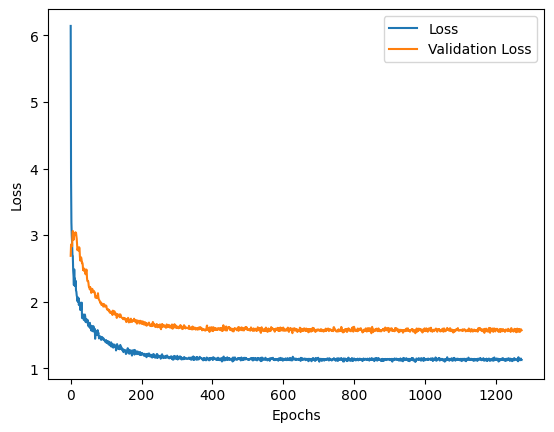

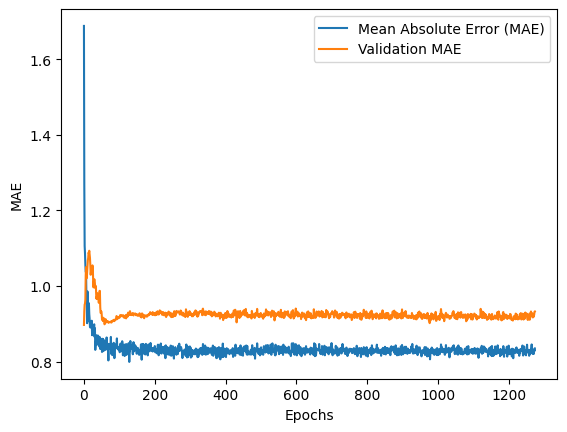

In [187]:
import matplotlib.pyplot as plt

history = train_away.history

plt.plot(history['loss'], label='Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history['mae'], label='Mean Absolute Error (MAE)')
plt.plot(history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [188]:
test_loss_home, test_mae_home = model_home.evaluate(x_test_home, y_test_home)
print(f"Test Loss: {test_loss_home}")
print(f"Test MAE: {test_mae_home}")

test_loss_away, test_mae_away = model_away.evaluate(x_test_away, y_test_away)
print(f"Test Loss: {test_loss_away}")
print(f"Test MAE: {test_mae_away}")

3/3 [==============================] - 0s 15ms/step - loss: 1.3545 - mae: 0.9488
Test Loss: 1.3545114994049072
Test MAE: 0.9488121867179871
3/3 [==============================] - 0s 8ms/step - loss: 1.4794 - mae: 0.8852
Test Loss: 1.4794037342071533
Test MAE: 0.8852159380912781


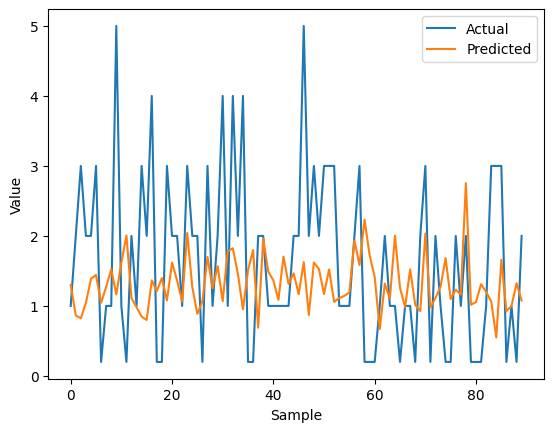

0.5486993287462507 2.752901119148601


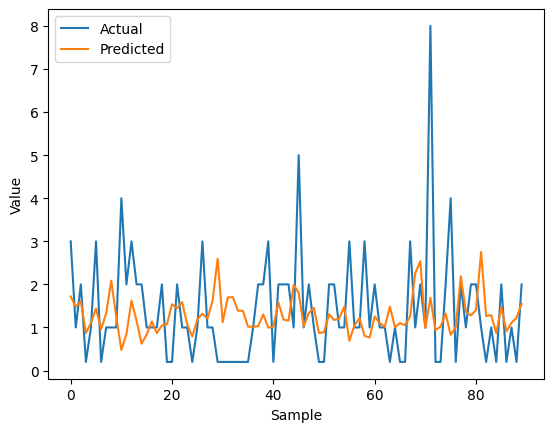

0.47747875929866357 2.752901119148601


In [189]:
y_pred_home = model.predict(x_test_home)  
plt.plot(y_test_home, label='Actual')
plt.plot(y_pred_home, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()
print(min(y_pred_home), max(y_pred_home))

y_pred_away = model.predict(x_test_away)  
plt.plot(y_test_away, label='Actual')
plt.plot(y_pred_away, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()
print(min(y_pred_away), max(y_pred_away))